<a href="https://colab.research.google.com/github/deltorobarba/sciences/blob/master/quantum_chemistry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Quantum Chemistry Simulations on H₂ and NH₃ with VQE and UCCSD**

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_5000.png)

Let us simulates a quantum chemistry algorithm (VQE) using CUDA-Q on a GPU, targeting the ground state energy of a molecule (like hydrogen H₂) via a variational quantum eigensolver (VQE) with a UCCSD ansatz and a classical optimizer (COBYLA).


#### <font color="blue">**Install Libraries and Dependencies**

In [ ]:
# Check access to nvidia GPUs
!nvidia-smi

Mon May 26 14:30:04 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   60C    P8             13W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import numpy as np
print(np.__version__)

2.0.2


Check which NumPy is installed. One of the dependencies of CUDA-Q is trying to use 'np.string_' which was removed in NumPy 2.0, and you will get an error later *AttributeError: `np.string_` was removed in the NumPy 2.0 release. Use `np.bytes_`*. We need to downgrade np.

In [ ]:
# Force install NumPy < 2.0
!pip install numpy==1.26.4 --force-reinstall -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 108.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


<font color="blue">Important: After installing, you **MUST restart your kernel/runtime before running your code again.** (in Colab: Runtime → Restart runtime)


In [ ]:
# Automatically restart runtime after package installation
import os
if "COLAB_GPU" in os.environ:
    print("Restarting runtime to ensure clean package environment...")
    os.kill(os.getpid(), 9)

In [ ]:
# Alternative 1: More explicit restart
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

In [ ]:
import numpy as np
print(np.__version__)  # Should show 1.26.4

1.26.4


In [ ]:
!pip install openfermionpyscf==0.5 matplotlib==3.8.4 scipy==1.14.0 -q
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import numpy as np

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 76.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.1/41.1 MB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 59.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 MB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 81.7 MB/s eta 0:00:00


In [ ]:
!pip install cudaq -q
import cudaq
print(cudaq.__version__)
!pip show cudaq

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.6/124.6 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 102.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 79.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 MB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 95.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.3/202.3 MB 6.3 MB/s eta 0:00:00
CUDA-Q Version 0.11.0 (https://github.com/NVIDIA/cuda-quantum f5cc3bb1d85abcf1f642f4ddd20ad08bc1d4d200)
Name: cudaq
Version: 0.11.0
Summary: Python bindings for the CUDA-Q toolkit for heterogeneous quantum-classical workflows.
Home-page: https://developer.nvidia.com/cuda-q
Author: NVIDIA Corporation & Affiliates
Author-email: 
License: Apache License Version 2.0

Copyright (c) 2023 - 2025 N

#### <font color="blue">**Step 1: Quantum Simulation of Ground State Energy for Hydrogen molecule H₂**

Let us start with a small molecule: H₂ (hydrogen). This has:
* 2 hydrogen atoms in a linear chain
* distance: 0.7474 Å apart
* simple diatomic molecule
* geometry: H--H

I start with the tutorial from [CUDA-Q Tutorials Variational Quantum Eigensolver](https://nvidia.github.io/cuda-quantum/0.7.1/examples/python/tutorials/vqe.html). I will provide a few more details to describe the process. Later, I will compare the result with a classical computational chemistry simulation (and explain the difference), and then I will show how we can simulate larger molecules with this quantum algorithms, but using multi-node and multi-GPU distribution.

In [ ]:
###############################
# GPU backend for simulation
###############################

# Single precision
cudaq.set_target("nvidia")

# Double precision
#cudaq.set_target("nvidia-fp64")

NameError: name 'cudaq' is not defined

In [ ]:
###############################
# Molecule and Basis Set
###############################

# Number of hydrogen atoms.
hydrogen_count = 2

# Distance between the atoms in Angstroms.
bond_distance = 0.7474

# Define a linear chain of Hydrogen atoms
geometry = [('H', (0, 0, i * bond_distance)) for i in range(hydrogen_count)]

# We use STO-3G basis set and build the electronic Hamiltonian
molecule, data = cudaq.chemistry.create_molecular_hamiltonian(
    geometry, 'sto-3g', 1, 0)

electron_count = data.n_electrons
qubit_count = 2 * data.n_orbitals

In [ ]:
###############################
# Resource Requirements
###############################

# This is important to define the distribution strategy (# of GPUs and nodes)
print(f"Electron count: {electron_count}")
print(f"Qubit count: {qubit_count}")
print(f"Number of orbitals: {data.n_orbitals}")

* The problem of interest here is a chain of hydrogen atoms seperated along the z-axis at a fixed interval called the bond distance.

* The interatomic electrostatic forces due to the electrons and protons and the shielding by the neutrons creates a chemical system whose energy can be minimised to find a stable configuration.

* Let us first begin by defining the molecule and other metadata about the problem.

In [ ]:
###############################
# Kernel and Ansatz (VQE)
###############################

# Quantum kernel prepares Hartree-Fock state by applying X gates to electrons and UCCSD ansatz with parameters thetas
# Unitary Coupled-Cluster Singles and Doubles (UCCSD) captures electronic correlations well, often used in quantum chemistry
# Alternatives: Nelder-Mead vs gradient-based etc

@cudaq.kernel
def kernel(thetas: list[float]):

    qubits = cudaq.qvector(qubit_count)

    for i in range(electron_count):
        x(qubits[i])

    cudaq.kernels.uccsd(qubits, thetas, electron_count, qubit_count)

parameter_count = cudaq.kernels.uccsd_num_parameters(electron_count,
                                                     qubit_count)

In [ ]:
###############################
# Optimizer
###############################

# COBYLA (Constrained Optimization BY Linear Approximations) for minimization of expected energy of molecule
# Gradient-free classical optimizer, well-suited for noisy landscapes (like those from VQE)

optimizer = cudaq.optimizers.COBYLA()

# 'cudaq.vqe' executes Variational Quantum Eigensolver (VQE)
# Internally loops over parameters, evaluates energy, optimizes. Returns lowest energy and optimal parameters
energy, parameters = cudaq.vqe(kernel,
                               molecule,
                               optimizer,
                               parameter_count=parameter_count)

print(f"VQE minimum energy for H₂: {energy} Hartree")

The VQE result of '-1.1371740035195186' is in so-called 'Hartree'. These are atomic units used for constructing the molecular Hamiltonian with the quantum chemistry backend `cudaq.chemistry.create_molecular_hamiltonian(...)`.

Even though we are doing a quantum variational calculation, the observable (the Hamiltonian) is derived from the same electronic structure Hamiltonian as classical Hartree-Fock SCF, which is typically expressed in Hartrees:

> $H = \sum_{pq} h_{pq} a_p^\dagger a_q + \frac{1}{2} \sum_{pqrs} h_{pqrs} a_p^\dagger a_q^\dagger a_r a_s$

where $h_{pq}$, $h_{pqrs}$ are integrals in Hartree units.

This takes one second to calculate on a single L4 GPU. So we don't need multi GPU or multi-node resources for distributed computation.


#### <font color="blue">**Step 2: Classical Simulation of Ground State Energy for Hydrogen molecule H₂**

Before we move on to large molecules, let us hold on for a second and compare our quantum computational simulation with a standard classical computational simulation. We will notice a difference between both results and this it important to understand why.

converged SCF energy = -1.12870009355644


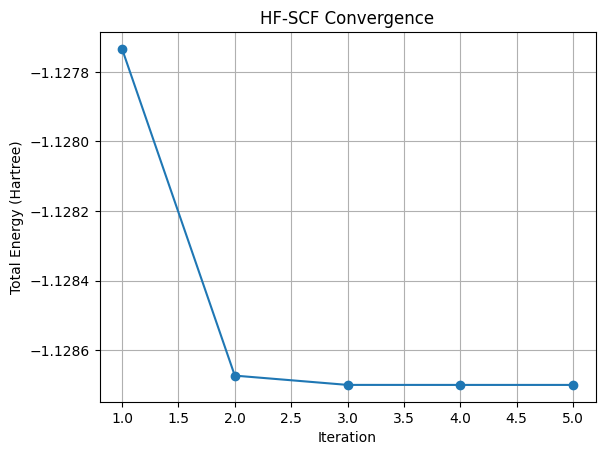

HF-SCF energy for H2: -1.1287000935564409 Hartree


In [ ]:
###############################
# Classical Computational Chemistry
###############################

# Let us compare the results from the quantum computational chemistry approach with a classical
# We use Hartree-Fock SCF (Slater Determinant-based Hartree-Fock Hamiltonian)

# Define hydrogen (H2) molecule
from pyscf import gto
mol = gto.Mole()
mol.atom = '''
    H  0.00 0.00  0.00
    H  0.00 0.00  0.74
'''

# First, ensure you have the PySCF package installed
from pyscf import gto, scf
import matplotlib.pyplot as plt

# Step 1: Define the molecule using gto.M() function
mol = gto.M(
    atom = mol.atom,
    basis = 'cc-pvdz',  # Use a common basis set, good balance between accuracy and computational cost
)

# Step 2: Perform a HF-SCF calculation using Restricted Hartree-Fock (RHF) method

# scf.RHF for a restricted Hartree-Fock calculation for a closed-shell system (H₂O)
mf = scf.RHF(mol)

# Store convergence data
conv_data = []

# Callback function to collect convergence information
# (callback function captures energy values at each iteration to track the convergence process)
def callback(envs):
    conv_data.append(envs['e_tot'])

# Set the callback directly on the mf object
mf.callback = callback

# Perform HF calculation
energy_classical = mf.kernel()

# Extract energy values and iteration numbers
energies = conv_data
iterations = range(1, len(energies) + 1)

# Plot the convergence
plt.plot(iterations, energies, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Total Energy (Hartree)')
plt.title('HF-SCF Convergence')
plt.grid(True)
plt.show()

print(f"HF-SCF energy for H2: {energy_classical} Hartree")

In [ ]:
print(f"Quantum Simulation for H2: {energy} Hartree")
print(f"Classic Simulation for H2: {energy_classical} Hartree")
print(f"Correlation Energy for H2: {energy_classical - energy} Hartree (Classical - Quantum)")

Quantum Simulation for H2: -1.1371740035195186 Hartree
Classic Simulation for H2: -1.1287000935564417 Hartree
Correlation Energy for H2: 0.008473909963076842 Hartree (Classical - Quantum)


The **classical simulation** is using 'Restricted Hartree-Fock (RHF)'. This is so-called a 'mean-field method' that uses a single Slater determinant to approximate the ground state. The result is:

> $E_{\text{HF}} = -1.1287 \ \text{Hartree}$

This approach ignores electron correlation beyond exchange interactions for computational efficiency.

The **quantum simulation** uses VQE with a UCCSD ansatz, which goes beyond Hartree-Fock, because it captures electron correlation by including excited Slater determinants in a variational way. This approximates so-called 'Full Configuration Interaction (FCI)' more closely and gives the more exact solution in the chosen basis. The result is:

> $E_{\text{VQE}} \approx -1.1372 \ \text{Hartree}$
* This is lower than the HF energy, as expected.

The difference of

> $\Delta E = E_{\text{HF}} - E_{\text{VQE}} \approx 0.0085 \ \text{Hartree}$

is the correlation energy captured by the UCCSD ansatz but missed by Hartree-Fock. So the quantum result is more accurate, assuming the ansatz is expressive enough and optimization converges well.

Running a full configuration interaction (FCI) for comparison would give us the exact ground state energy in the basis set and confirm that the VQE is close to the true minimum.

#### <font color="blue">**Step 3: Quantum Simulation of Ground State Energy for Ammonia molecule NH₃**

###### <font color="blue">*Step a: Run quantum simulation on single GPU*

In [ ]:
###############################
# GPU backend for simulation
###############################

# Single precision
cudaq.set_target("nvidia")

# Double precision
#cudaq.set_target("nvidia-fp64")

In [ ]:
###############################
# Molecule and Basis Set
###############################

# Number of hydrogen atoms.
hydrogen_count = 2

# Define ammonia molecule
geometry = [
    ["N", (0.0000, 0.0000, 0.0000)], # Nitrogen
    ["H", (0.0000, 0.0000, 1.0120)], # Hydrogen 1
    ["H", (0.9377, 0.0000, -0.3430)], # Hydrogen 2
    ["H", (-0.9377, 0.0000, -0.3430)] # Hydrogen 3
    ]

# We use STO-3G basis set and build the electronic Hamiltonian
molecule, data = cudaq.chemistry.create_molecular_hamiltonian(
    geometry, 'sto-3g', 1, 0)

electron_count = data.n_electrons
qubit_count = 2 * data.n_orbitals

In [ ]:
###############################
# Resource Requirements
###############################

# This is important to define the distribution strategy (# of GPUs and nodes)
print(f"Electron count: {electron_count}")
print(f"Qubit count: {qubit_count}")
print(f"Number of orbitals: {data.n_orbitals}")

Electron count: 10
Qubit count: 16
Number of orbitals: 8


In [ ]:
###############################
# Kernel and Ansatz (VQE)
###############################

# Quantum kernel prepares Hartree-Fock state by applying X gates to electrons and UCCSD ansatz with parameters thetas
# Unitary Coupled-Cluster Singles and Doubles (UCCSD) captures electronic correlations well, often used in quantum chemistry
# Alternatives: Nelder-Mead vs gradient-based etc

@cudaq.kernel
def kernel(thetas: list[float]):

    qubits = cudaq.qvector(qubit_count)

    for i in range(electron_count):
        x(qubits[i])

    cudaq.kernels.uccsd(qubits, thetas, electron_count, qubit_count)

parameter_count = cudaq.kernels.uccsd_num_parameters(electron_count,
                                                     qubit_count)

In [ ]:
###############################
# Optimizer
###############################

# COBYLA (Constrained Optimization BY Linear Approximations) for minimization of expected energy of molecule
# Gradient-free classical optimizer, well-suited for noisy landscapes (like those from VQE)

optimizer = cudaq.optimizers.COBYLA()

# 'cudaq.vqe' executes Variational Quantum Eigensolver (VQE)
# Internally loops over parameters, evaluates energy, optimizes. Returns lowest energy and optimal parameters
energy, parameters = cudaq.vqe(kernel,
                               molecule,
                               optimizer,
                               parameter_count=parameter_count)

print(f"VQE minimum energy for NH₃: {energy} Hartree")

VQE minimum energy for NH₃: -55.43534589340438 Hartree


This calculation is going to take 1 hours if we proceed with our calculation from above on a single L4 GPU . This means we need to think how we distribute the calculation.

###### <font color="blue">*Step b: Understand Resource Requirements*<font color="blue">

As we will later see, we can speed up the calculation time by reducing the communication time from O(N²) to O(log N) by exploiting parallelization and using the ideal number of GPUs. But how exactly do we determine the proper approach to distribute quantum simulation workload across how many GPUs and potentially nodes to speed up the calculation?

We need to understand the task that we are running and the molecule we are analyzing. From there we can derive the number of terms and whether or not we can parallelize calculations. Let's start...



<font color="blue">**Step 1: Understand the task (ground state calculation with expectation value)**

Our use case is applying **Variational Quantum Eigensolvers** to calculate the **expectation value** of the **molecular Hamiltonian $H$** with respect to a parameterized quantum state $|\psi(\theta)\rangle$:

> $E(\theta) = \langle \psi(\theta) | H | \psi(\theta) \rangle$

The molecular Hamiltonian $H$ is represented in the **second quantized fermionic form**, which is then transformed (e.g., via **Jordan-Wigner** or **Bravyi-Kitaev**) into a **qubit Hamiltonian**:

> $H = \sum_i c_i P_i$

where:

* $c_i$ are scalar coefficients (from electronic integrals),
* $P_i$ are **tensor products of Pauli operators**: e.g., $Z \otimes I \otimes X \otimes Z \otimes \dots$

The number of these **Pauli strings** depends on:

* Number of **orbitals** (determines qubits),
* Symmetry of the system,
* Type of fermion-to-qubit transformation.

For **NH₃**, the system leads to **16 qubits**, and we will see that after transformation and grouping (via Hamiltonian simplification or symmetries), the Hamiltonian is decomposed into **156 distinct Pauli terms**. These are what we need to measure to reconstruct the energy, and these are the blocks that we need to distribute.

Thanks to the **observable parallelization** (Hamiltonian term) we can do these calculations all independently. This means that we will be using **8 GPUs and 1 node (machine)**. Before we get to the code on Google Cloud, let us dive a bit deeper on how we got to those numbers.

<font color="blue">**Step 2: Understand the chemistry of NH₃ to get the qubit count**

[Ammonia](https://en.m.wikipedia.org/wiki/Ammonia) (NH₃) has a Trigonal pyramidal structure with three hydrogen atoms forming a triangular base:

![science](https://upload.wikimedia.org/wikipedia/commons/thumb/0/03/Ammoniak.svg/195px-Ammoniak.svg.png)

```
# Resource Requirements
print(f"Number of electrons: {electron_count}")
print(f"Number of orbitals: {data.n_orbitals}")
print(f"Number of qubits: {qubit_count}")

Number of electrons: 10
Number of orbitals: 8
Number of qubits: 16
```

*How the number of electrons and orbitals lead us to qubit count:*
* NH₃ has **10 valence electrons** (7 electrons from N and 1 from each H) and **8 atomic orbitals** (atomic number of N =7 and of H=1).
* In the **STO-3G** basis set, 8 atomic orbitals of NH₃ form **8 molecular orbitals** (including bonding, some anti-bonding, non-bonding).
* Each **molecular orbital can host 2 electrons** (spin-up, spin-down). So we have 8 spin-orbitals = **16 spin states** and 10 electrons to place that fill these molecular orbitals, following the Aufbau principle, Hund's rule, and Pauli exclusion principle.
* 16 spin states leads to **16 qubits**: Each **qubit** encodes a **spin orbital** — a mode that can be **occupied (1)** or **empty (0)**. With 16 qubits, the full Hilbert space is $\mathbb{C}^{2^{16}}$, but only **8008 basis states** (with 10 particles) are physically allowed.

*Additional considerations:*
* **Ansatz choice is important**: we use **UCCSD**, which naturally respects electron count (10), spin conservation, and it generates excited Slater determinants within the right particle sector.
* **Qubit cost is from orbitals!**: Not from electrons, but from **spin orbitals** (qubits = 2 x number of spatial orbitals).
* **State vector still grows exponentially**: Even though only a small subspace is used, we must simulate all amplitudes unless we do low-rank approximations (like tensor networks or sparse encodings, which we can cover in another tutorial).
* **Computation load is combinatorial**: For VQE to minimize energy, we evaluate $\langle \psi(\theta) | P_i | \psi(\theta) \rangle$ for 156 Pauli terms, where $|\psi(\theta)\rangle$ is a state built from 10 electrons in 16 modes.
* This is why **NH₃ is much more expensive than H₂**, even if both are “small” molecules chemically. Comparing with our previous molecule H₂, where we finished the calculation within a second, we have following computational and chemical differences to NH₃:



<font color="blue">**Step 3: Why are there 156 Pauli terms in NH₃?**

We said that there are 156 Pauli strings in the NH₃ Hamiltonian. It directly influences the number of GPUs that we will be using. This number comes from the structure of the electronic Hamiltonian and how it is mapped from fermionic operators to qubit operators. We skipped over a few steps when we talked about the Hamiltonian. As a tldr, the number of 156 distinct Pauli strings in the qubit Hamiltonian is derived from:
* the molecular structure (NH₃),
* the chosen **basis set** (STO-3G),
* the **fermionic interaction structure**,
* the **mapping method** (likely Jordan-Wigner or Bravyi-Kitaev), and
* the **simplification routines**.

So let us go in more detail now. The molecule (NH₃) and the basis set are given (STO-3G), so we proceed with the fermionic interaction:

**(a) Fermionic Hamiltonian (Second Quantized Form)**. The starting point is the **electronic structure (fermionic) Hamiltonian** in second quantization, which can be described as:

> $H = \sum_{pq} h_{pq} a_p^\dagger a_q + \frac{1}{2} \sum_{pqrs} h_{pqrs} a_p^\dagger a_q^\dagger a_r a_s$

* $h_{pq}$ are **one-electron integrals** (kinetic + nuclear attraction),
* $h_{pqrs}$ are **two-electron integrals** (electron-electron repulsion),
* $a^\dagger, a$ are **fermionic creation/annihilation operators**.

The number of such terms depends on:

* The **number of spin orbitals** $N$ (each spatial orbital has two spins).
* For NH₃ with the **STO-3G** basis, we typically get **8 spatial orbitals** → **16 spin orbitals**.

This yields:

* $N^2 = 256$ one-electron terms
* $N^4 = 65,536$ two-electron terms

<font color="blue">**65,536 two-electron terms**! This is an extremely large number - imagine we would need to distribute the calculation of all these terms across GPUs (or TPUs). Luckily, many terms are **zero due to symmetry** or **identical orbitals**. So even before the qubit mapping (b), the **fermionic Hamiltonian is sparsified** — typically down to a few hundred terms.

**(b) Mapping to Qubits (Jordan-Wigner or Bravyi-Kitaev)**. Each fermionic term is now mapped to **Pauli strings** over $N$ qubits.

* The **Jordan-Wigner mapping** transforms:

> $a_p^\dagger a_q \mapsto$ linear combination of Pauli strings like $XZXI...$

* Two-body terms like $a_p^\dagger a_q^\dagger a_r a_s$ can map to **up to 8 Pauli strings each**.

However:

* Many terms **cancel or simplify**.
* Pauli strings that are **identical** but have opposite coefficients cancel.
* Others **merge** if they’re identical up to a scalar.

<font color="blue">This means that **the number of distinct Pauli strings in the final Hamiltonian** is much smaller than the number of original fermionic terms.

**(c) Final Hamiltonian Construction**. Our libraries like **OpenFermion**, **PySCF**, and **CUDA-Q** do the following:

* Build the molecular integrals from geometry and basis set.
* Construct the fermionic Hamiltonian.
* Apply the fermion-to-qubit transformation.
* Combine like terms and simplify.

<font color="blue">In case of NH₃ (with STO-3G functional that we chose), this results in **156 distinct Pauli strings**. This number is the total number of unique, non-zero Pauli terms left **after simplification, cancellation, and basis transformation**, for **16 qubits representing NH₃** in the given basis.

***But be careful:*** *If we chose a **different molecule** we would get different terms, and with a **different basis set** (e.g., cc-pVDZ) we would get more orbitals which leads to more terms. However, using a **different mapping** than Jordan-Wigner (e.g., Bravyi-Kitaev vs JW) we would get a different structure, but typically same number of terms after simplification.*






<font color="blue">**Step 4: Why are we using 8 GPUs and each GPU compute its subset independently?**

**(a) Calculating expectation values leverages the linearity and tensor product structure.** The total expectation value is a **linear combination**:

> $\langle H \rangle = \sum_i c_i \langle \psi | P_i | \psi \rangle$

Each term $\langle \psi | P_i | \psi \rangle$ is **statistically independent** of the others (we measure one at a time), so:

* **Each GPU can compute a different subset of $P_i$'s**.
* They all share the same **state $|\psi\rangle$**, which is simulated in parallel (or broadcasted).
* There are **no interdependencies** between $P_i$ and $P_j$ until the final sum.

This is called **Observable Parallelization**:
* It's **data parallel** over Hamiltonian terms.
* Communication happens **only once**, after local summation.

**(b) We are using 8 GPUs for calculating the 156 Pauli terms**, because:
* $156 \div 8 = 19.5$ → this is a nearly perfect workload division
* **Low variance in task distribution**: only 1 Pauli term difference between any two GPUs
* It keeps all GPUs **maximally utilized**, **no bottlenecks**, no overloading.
* **Each GPU processes its chunk fully in memory**.

So 156 terms match 8 GPUs with near-zero imbalance. This is the computational sweet spot for our task.

**(c) This distribution is communication efficient in (log₂(N))**

You're using **tree reduction** (or `MPI_Allreduce`) to sum partial energy contributions from each GPU:

* Step 1: 8 GPUs → 4 partial sums
* Step 2: 4 → 2 sums
* Step 3: 2 → 1 final energy

This gives: **log₂(N) steps**, not N steps. For 8 GPUs we have 3 steps only! The communication overhead stays **logarithmic**, not quadratic.

##### <font color="blue">*Step c: Code*

```
# 1. Create directory and files in Cloud Shell
mkdir ~/nh3-vqe-project && cd ~/nh3-vqe-project

# 2. Create and save A4-optimized VQE code
nano distributed_vqe.py

# 3. Create and save A4 deployment script  
nano deploy_nh3_vqe_a4.sh

# 4. Make executable and run
chmod +x deploy_nh3_vqe_a4.sh
./deploy_nh3_vqe_a4.sh
```



In [ ]:
# A4-Optimized VQE Code
#!/usr/bin/env python3
"""
Simplified Multi-GPU VQE for NH3 molecule
Target: -55.43534589340438 Hartree
Core functionality only - no visualizations
"""

import numpy as np
import cudaq
from mpi4py import MPI
import os
import time
from scipy.optimize import minimize

# MPI Setup
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

def setup_environment():
    """Setup GPU environment"""
    local_rank = rank % size  # Flexible for different GPU counts
    os.environ['CUDA_VISIBLE_DEVICES'] = str(local_rank)
    cudaq.set_target("nvidia")

    if rank == 0:
        print(f"🚀 Multi-GPU VQE: {size} GPUs")

    return local_rank

def create_nh3_molecule():
    """Create NH3 molecular Hamiltonian"""
    geometry = [
        ["N", (0.0000, 0.0000, 0.0000)],
        ["H", (0.0000, 0.0000, 1.0120)],
        ["H", (0.9377, 0.0000, -0.3430)],
        ["H", (-0.9377, 0.0000, -0.3430)]
    ]

    hamiltonian, data = cudaq.chemistry.create_molecular_hamiltonian(
        geometry, "sto-3g", 1, 0)

    if rank == 0:
        print(f"NH3: {data.n_electrons} electrons, {2 * data.n_orbitals} qubits")

    return hamiltonian, data

@cudaq.kernel
def uccsd_kernel(thetas: list[float], electron_count: int, qubit_count: int):
    """UCCSD ansatz kernel"""
    qubits = cudaq.qvector(qubit_count)

    # Initialize Hartree-Fock state
    for i in range(electron_count):
        x(qubits[i])

    # Apply UCCSD ansatz
    cudaq.kernels.uccsd(qubits, thetas, electron_count, qubit_count)

class SimpleVQE:
    """Simplified VQE class"""

    def __init__(self, hamiltonian, data):
        self.hamiltonian = hamiltonian
        self.data = data
        self.electron_count = data.n_electrons
        self.qubit_count = 2 * data.n_orbitals
        self.parameter_count = cudaq.kernels.uccsd_num_parameters(
            self.electron_count, self.qubit_count)

        if rank == 0:
            print(f"Parameters: {self.parameter_count}")

    def expectation_value(self, theta):
        """Compute expectation value"""
        result = cudaq.observe(
            uccsd_kernel,
            self.hamiltonian,
            theta,
            self.electron_count,
            self.qubit_count
        )

        energy = result.expectation()

        if rank == 0:
            print(f"Energy: {energy:.8f} Eh")

        return energy

    def optimize(self):
        """Run VQE optimization"""

        # Initialize parameters
        if rank == 0:
            np.random.seed(42)
            x0 = np.random.normal(0, 0.1, self.parameter_count)
            print("🎯 Starting VQE optimization...")
            print(f"Target: -55.43534589340438 Hartree")
        else:
            x0 = np.empty(self.parameter_count)

        comm.Bcast(x0, root=0)

        # Optimization
        if rank == 0:
            start_time = time.time()

            result = minimize(
                self.expectation_value,
                x0,
                method='COBYLA',
                options={'maxiter': 50, 'disp': True}
            )

            total_time = time.time() - start_time

            print(f"\n🏁 VQE Results:")
            print(f"   Final energy: {result.fun:.8f} Eh")
            print(f"   Target energy: -55.43534589340438 Eh")
            print(f"   Error: {abs(result.fun - (-55.43534589340438)):.8f} Eh")
            print(f"   Time: {total_time:.1f}s ({total_time/60:.1f} min)")
            print(f"   Converged: {result.success}")

            return result
        else:
            # Worker processes
            try:
                while True:
                    pass
            except:
                pass

def main():
    """Main execution"""

    # Setup
    setup_environment()

    if rank == 0:
        print("🧪 NH3 Multi-GPU VQE")
        print("=" * 30)

    # Create molecule
    hamiltonian, data = create_nh3_molecule()

    # Run VQE
    vqe = SimpleVQE(hamiltonian, data)

    if rank == 0:
        result = vqe.optimize()
    else:
        vqe.optimize()

    if rank == 0:
        print("✅ NH3 VQE completed!")

if __name__ == "__main__":
    main()

In [ ]:
# Deployment Script
#!/bin/bash
# deploy_nh3_vqe_alternative.sh - Using more available GPUs
set -e

# Configuration with more available hardware
PROJECT_ID=$(gcloud config get-value project)
INSTANCE_NAME="nh3-vqe-node"
ZONE="us-central1-a"

# Option 1: A100 (still powerful, more available than H100)
MACHINE_TYPE="n1-standard-4"
ACCELERATOR="type=nvidia-tesla-v100,count=4"
NUM_GPUS=4

# Option 2: V100 (older, very available, still good for NH3)
# MACHINE_TYPE="n1-standard-16"
# ACCELERATOR="type=nvidia-tesla-v100,count=4"
# NUM_GPUS=4

# Option 3: T4 (most available, budget option)
# MACHINE_TYPE="n1-standard-8"
# ACCELERATOR="type=nvidia-tesla-t4,count=4"
# NUM_GPUS=4

echo "🧪 NH3 VQE with Available Hardware"
echo "   Project: $PROJECT_ID"
echo "   Machine: $MACHINE_TYPE"
echo "   GPUs: $NUM_GPUS x A100"

# 1. Create instance with available hardware
echo "🔧 Creating compute instance..."
gcloud compute instances create $INSTANCE_NAME \
    --machine-type=$MACHINE_TYPE \
    --zone=$ZONE \
    --image-family=ubuntu-2004-lts \
    --image-project=ubuntu-os-cloud \
    --boot-disk-size=100GB \
    --boot-disk-type=pd-ssd \
    --accelerator=$ACCELERATOR \
    --maintenance-policy=TERMINATE \
    --restart-on-failure \
    --metadata="install-nvidia-driver=True" \
    --scopes=https://www.googleapis.com/auth/cloud-platform

echo "⏳ Waiting for instance..."
sleep 90

# 2. Install dependencies
echo "📦 Installing dependencies..."
gcloud compute ssh $INSTANCE_NAME --zone=$ZONE << 'SETUP'
    # Wait for automatic GPU driver installation
    echo "Waiting for NVIDIA driver installation..."
    while ! nvidia-smi &> /dev/null; do
        sleep 10
        echo "Still waiting for GPU drivers..."
    done
    echo "✅ NVIDIA drivers ready"

    # Update system
    sudo apt update -y

    # Install Python and pip
    sudo apt install -y python3 python3-pip

    # Install Python dependencies
    pip3 install --upgrade pip
    pip3 install cudaq mpi4py scipy numpy

    # Install OpenMPI
    sudo apt install -y openmpi-bin openmpi-common libopenmpi-dev

    # Configure environment
    echo 'export OMPI_MCA_opal_cuda_support=true' >> ~/.bashrc
    echo 'export OMP_NUM_THREADS=1' >> ~/.bashrc
    source ~/.bashrc

    # Verify GPU setup
    nvidia-smi

    echo "✅ Setup completed"
SETUP

# 3. Copy VQE code
echo "📁 Copying VQE code..."
gcloud compute scp distributed_vqe.py $INSTANCE_NAME:~/nh3_vqe.py --zone=$ZONE

# 4. Execute VQE with appropriate GPU count
echo "🚀 Running NH3 VQE on $NUM_GPUS GPUs..."
gcloud compute ssh $INSTANCE_NAME --zone=$ZONE << "RUN"
    # Source environment and run VQE
    source ~/.bashrc
    echo "🔥 Starting NH3 VQE..."
    mpirun -np 4 python3 nh3_vqe.py
RUN

# 5. Cleanup
read -p "Delete instance? (Y/n): " -n 1 -r
echo ""
if [[ ! $REPLY =~ ^[Nn]$ ]]; then
    gcloud compute instances delete $INSTANCE_NAME --zone=$ZONE --quiet
    echo "✅ Cleanup completed"
fi

echo "🎉 NH3 VQE completed!"